# Backtest: validation on historical data

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/102-backtest.ipynb)

This notebook contains the simple examples of time series validation using backtest module of ETNA library.

**Table of contents**

* [What is backtest and how it works](#chapter1)  
* [How to run a validation](#chapter2)
* [Backtest with fold masks](#chapter3)
* [Validation visualisation](#chapter4)
* [Metrics visualisation](#chapter5)

In [1]:
!pip install "etna[prophet]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.models import ProphetModel
from etna.pipeline import Pipeline

## 1. What is backtest and how it works <a class="anchor" id="chapter1"></a>

Backtest is a predictions and validation pipeline build on historical data to make a legitimate retrotest of your model.

<b>How does it work?</b>

When constructing a forecast using Models and further evaluating the prediction metrics, we measure the quality at one time interval, designated as test.

Backtest allows you to simulate how the model would work in the past:

* selects a period of time in the past

* builds a model using the selected interval as a training sample

* predicts the value on the test interval and calculates metrics.

The image shows a plot of the backtest pipeline with `n_folds = 3`.

![backtest-scheme](./assets/backtest/backtest.jpg)

Below we will call a fold the train + test pair, for which training and forecasting is performed.

In [4]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the special data structure TSDataset. So, before starting the EDA, we need to convert the DataFrame into TSDataset.

In [5]:
ts = TSDataset(df, freq="D")

Let's get a look on series

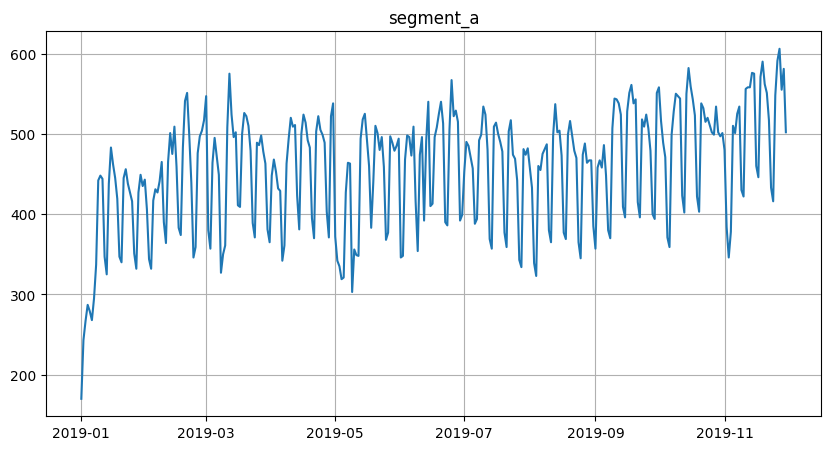

In [6]:
ts.plot(segments=["segment_a"])

## 2. How to run a validation <a class="anchor" id="chapter2"></a>

For an easy start let's create a Prophet model

In [7]:
horizon = 31  # Set the horizon for predictions
model = ProphetModel()  # Create a model
transforms = []  # A list of transforms -  we will not use any of them

### 2.1 Pipeline <a class="anchor" id="section_2_1"></a>

Now let's create an instance of `Pipeline`.

In [8]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

We are going to run `backtest` method for it. As a result, dict with four values will be returned: 

* `"metrics_df"` -> dataframe with metrics for each fold and each segment, 
* `"forecasts"` -> list of `TSDataset` with predictions for each fold, 
* `"fold_info"` -> dataframe with information about folds,
* `"pipelines"` -> list of fitted pipelines for each fold. 

In [9]:
backtest_result = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()])

metrics_df = backtest_result["metrics_df"]
forecast_ts_list = backtest_result["forecasts"]
fold_info_df = backtest_result["fold_info"]
pipelines = backtest_result["pipelines"]

17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Paralle

In [10]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,18.767513,590.353541,4.352958,0
0,segment_a,21.024423,673.091859,4.842295,1
0,segment_a,29.976157,1304.758852,6.273235,2
0,segment_a,35.982097,1998.590572,7.423427,3
0,segment_a,31.214272,1828.192965,6.323908,4


You can analyze the forecast for each fold separately:

In [11]:
first_fold_forecast_ts = forecast_ts_list[0]
first_fold_forecast_ts.head()

segment,segment_a
feature,target
timestamp,
2019-06-29,395.155925
2019-06-30,386.091359
2019-07-01,492.912703
2019-07-02,509.263813
2019-07-03,497.456891


Or you can easily combine all forecasts into one `pd.DataFrame`:

In [12]:
forecast_df = pd.concat([forecast_ts.to_pandas() for forecast_ts in forecast_ts_list], axis=0)
forecast_df

segment,segment_a
feature,target
timestamp,
2019-06-29,395.155925
2019-06-30,386.091359
2019-07-01,492.912703
2019-07-02,509.263813
2019-07-03,497.456891
...,...
2019-11-26,556.818865
2019-11-27,547.266304


And also add a column with the fold number:

In [13]:
forecast_df_with_fold_number = pd.concat(
    [
        TSDataset.to_dataset(forecast_ts.to_pandas(flatten=True).assign(fold_number=fold_number))
        for fold_number, forecast_ts in enumerate(forecast_ts_list)
    ],
    axis=0,
)
forecast_df_with_fold_number

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.155925
2019-06-30           0  386.091359
2019-07-01           0  492.912703
2019-07-02           0  509.263813
2019-07-03           0  497.456891
...                ...         ...
2019-11-26           4  556.818865
2019-11-27           4  547.266304
2019-11-28           4  539.895636
2019-11-29           4  527.216733
2019-11-30           4  441.261810

[155 rows x 2 columns]

In [14]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
1,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
2,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
3,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
4,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


In [15]:
for p in pipelines:
    print(p, end="\n\n")

Pipeline(model = ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'additive', seasonality_prior_scale = 10.0, holidays_prior_scale = 10.0, changepoint_prior_scale = 0.05, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), timestamp_column = None, ), transforms = [], horizon = 31, )

Pipeline(model = ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'additive', seasonality_prior_scale = 10.0, holidays_prior_scale = 10.0, changepoint_prior_scale = 0.05, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), ti

You can additionally get the metrics averaged over folds:

In [16]:
backtest_result = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], aggregate_metrics=True)

metrics_df = backtest_result["metrics_df"]
forecast_ts_list = backtest_result["forecasts"]
fold_info_df = backtest_result["fold_info"]

17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Paralle

In [17]:
metrics_df.head()

,segment,MAE,MSE,SMAPE
0,segment_a,27.392892,1278.997558,5.843165


In [18]:
forecast_df = pd.concat([forecast_ts.to_pandas() for forecast_ts in forecast_ts_list], axis=0)
forecast_df

segment,segment_a
feature,target
timestamp,
2019-06-29,395.155925
2019-06-30,386.091359
2019-07-01,492.912703
2019-07-02,509.263813
2019-07-03,497.456891
...,...
2019-11-26,556.818865
2019-11-27,547.266304


In [19]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
1,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
2,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
3,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
4,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


## 3. Backtest with fold masks<a class="anchor" id="chapter3"></a>

You can use your backtest strategies using `FoldMask`. In order to make a `FoldMask`, you need to specify `first_train_timestamp`, `last_train_timestamp`, `target_timestamps`. Then you need to pass a list of masks as the `n_folds` parameter to the `pipeline.backtest`.

Consider 3 strategies similar to `SlidingWindowSplitter`, `ExpandingWindowSplitter` and `SingleWindowSplitter` from `sktime`.

### 3.1 `ExpandingWindowSplitter` 

For this backtest strategy you can use our backtest with `mode="expand"`.

In [20]:
backtest_result = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=3, mode="expand")

metrics_df = backtest_result["metrics_df"]

17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed

In [21]:
metrics

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,29.976157,1304.758852,6.273235,0
0,segment_a,35.982097,1998.590572,7.423427,1
0,segment_a,31.214272,1828.192965,6.323908,2


### 3.2 `SingleWindowSplitter`

For this backtest strategy you can use our backtest with parameter `n_folds=1` or if you need specific window from your dataset you can create a mask with `FoldMask`.

In [22]:
from etna.pipeline import FoldMask

In [23]:
# 1 Without mask
backtest_result = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=1)

metrics_df = backtest_result["metrics_df"]

17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


In [24]:
metrics

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,31.214272,1828.192965,6.323908,0


In [25]:
# 2 With specific mask
window_size = 85
first_train_timestamp = ts.timestamps.min() + np.timedelta64(100, "D")
last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
mask = FoldMask(
    first_train_timestamp=first_train_timestamp,
    last_train_timestamp=last_train_timestamp,
    target_timestamps=target_timestamps,
)

In [26]:
# 2 With specific mask
backtest_result = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=[mask])

metrics_df = backtest_result["metrics_df"]

17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s


In [27]:
metrics

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914481,9.056343,0


### 3.3 `SlidingWindowSplitter`

To implement this backtest strategy you need to create a list of fold masks with `FoldMask`.

In [28]:
n_folds = 3

In [29]:
def sliding_window_masks(window_size, n_folds):
    masks = []
    for n in range(n_folds):
        first_train_timestamp = ts.timestamps.min() + np.timedelta64(100, "D") + np.timedelta64(n, "D")
        last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
        target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
        mask = FoldMask(
            first_train_timestamp=first_train_timestamp,
            last_train_timestamp=last_train_timestamp,
            target_timestamps=target_timestamps,
        )
        masks.append(mask)
    return masks

In [30]:
masks = sliding_window_masks(window_size=window_size, n_folds=n_folds)
backtest_result = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=masks)

metrics_df = backtest_result["metrics_df"]

17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
17:25:52 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed

In [31]:
metrics

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914481,9.056343,0
0,segment_a,40.293273,2287.327209,9.108208,1
0,segment_a,39.861470,2192.540584,9.010114,2


## 4. Validation visualisation <a class="anchor" id="chapter4"></a>

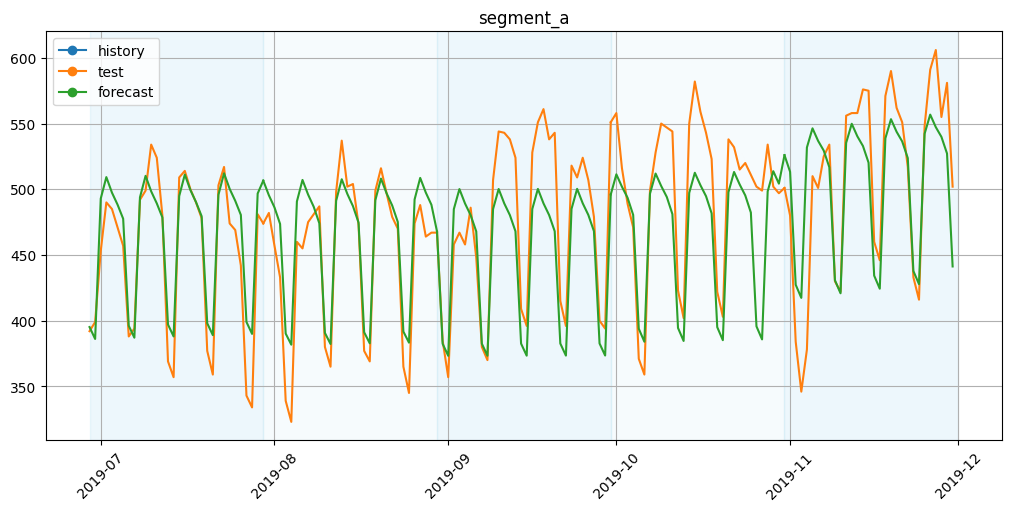

In [32]:
plot_backtest(forecast_ts_list, ts)

To visualize the train part, you can specify the `history_len` parameter. 

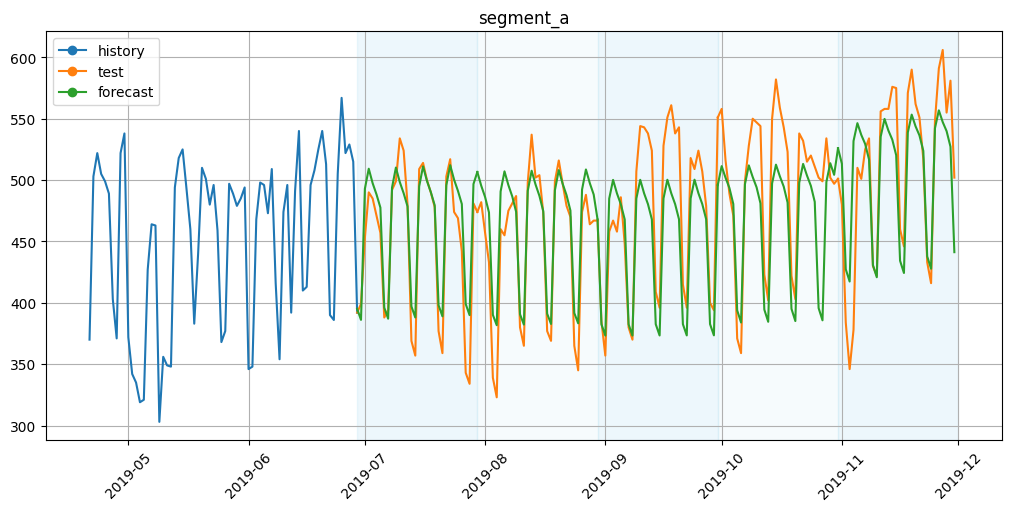

In [33]:
plot_backtest(forecast_ts_list, ts, history_len=70)

## 5. Metrics visualization  <a class="anchor" id="chapter5"></a>

In this section we will analyze the backtest results from the different point of views. 

In [34]:
from etna.analysis import metric_per_segment_distribution_plot
from etna.analysis import plot_metric_per_segment
from etna.analysis import plot_residuals
from etna.analysis import prediction_actual_scatter_plot

In [35]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
ts_all = TSDataset(df, freq="D")

In [36]:
backtest_result = pipeline.backtest(ts=ts_all, metrics=[MAE(), MSE(), SMAPE()])

metrics_df = backtest_result["metrics_df"]
forecast_ts_list = backtest_result["forecasts"]
fold_info_df = backtest_result["fold_info"]

17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 task

Let's look at the distribution of the SMAPE metric by folds. You can set `type_plot` as `box`, `violin` or `hist`.

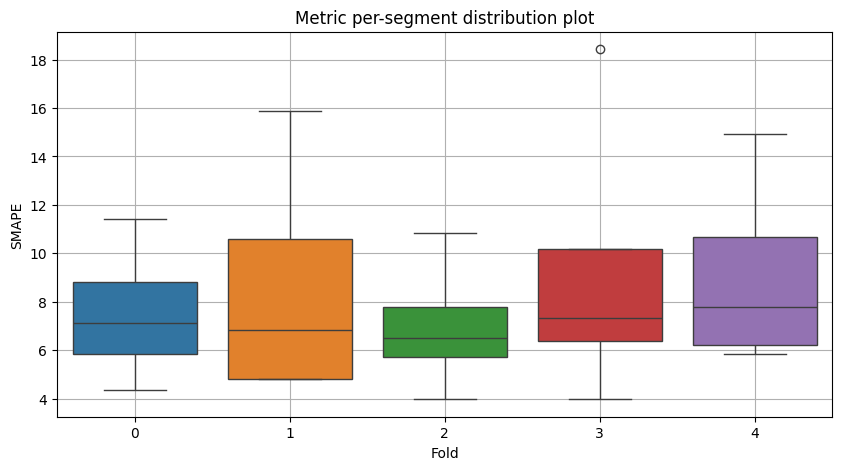

In [37]:
metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="SMAPE", plot_type="box")

Let's look at the SMAPE metric by segments

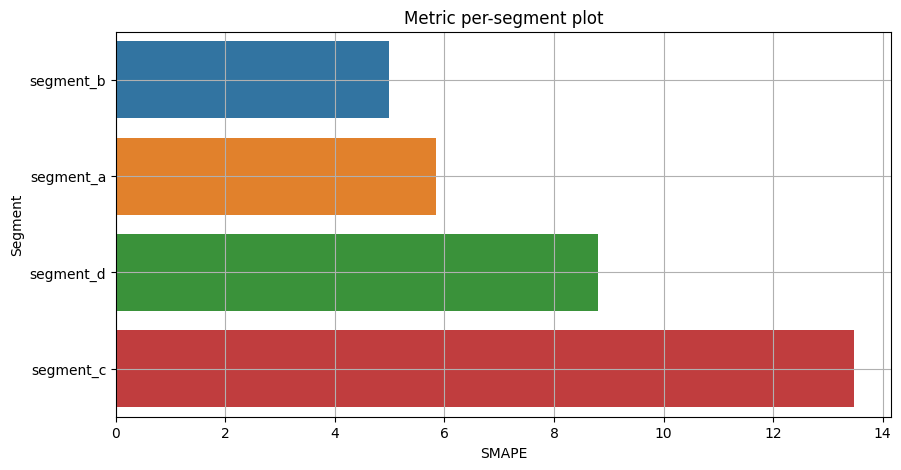

In [38]:
plot_metric_per_segment(metrics_df=metrics_df, metric_name="SMAPE", ascending=True)

Now let's look at the residuals of the model predictions from the backtest. Analysis of the residuals can help establish a dependency in the data that our model was not able to find. This way we can add features or improve the model or make sure that there is no dependency in the residuals. Also, you can visualize the residuals not only by timestamp but by any feature.

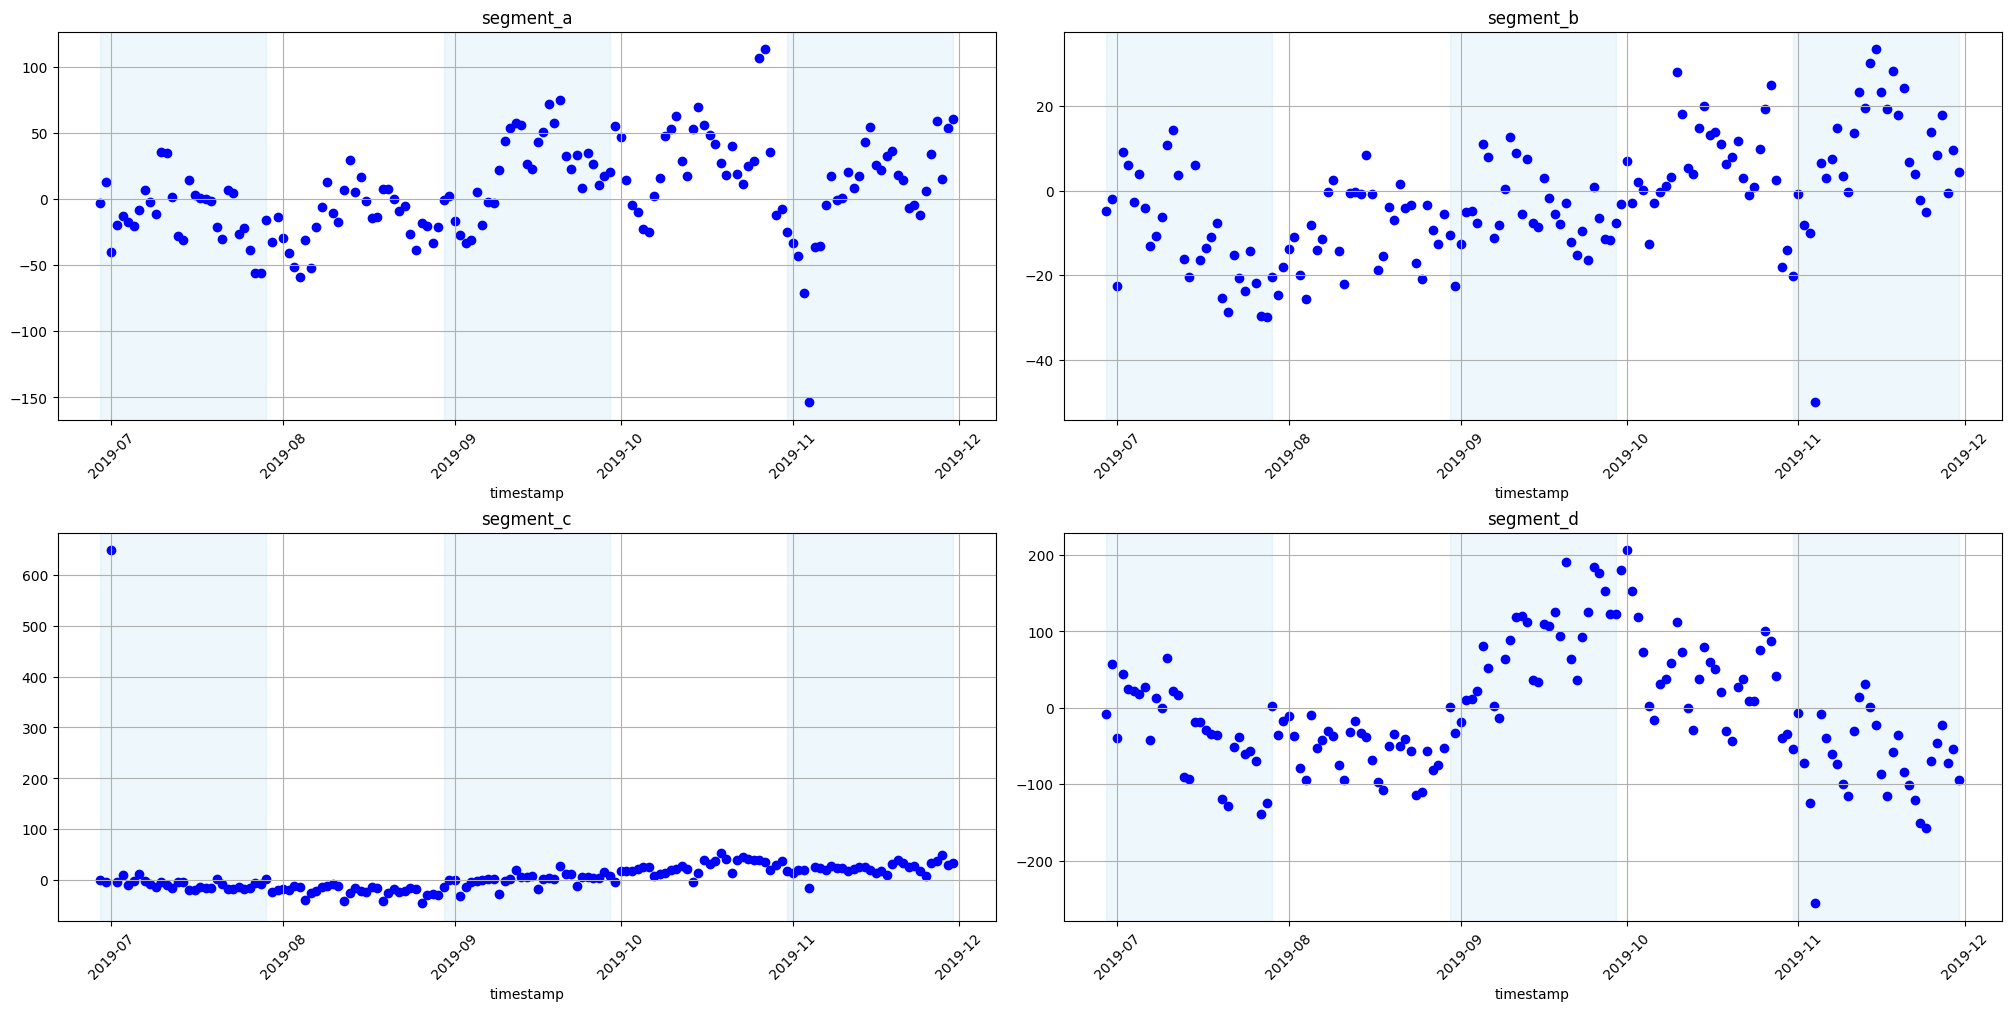

In [39]:
plot_residuals(forecast_ts_list=forecast_ts_list, ts=ts_all)

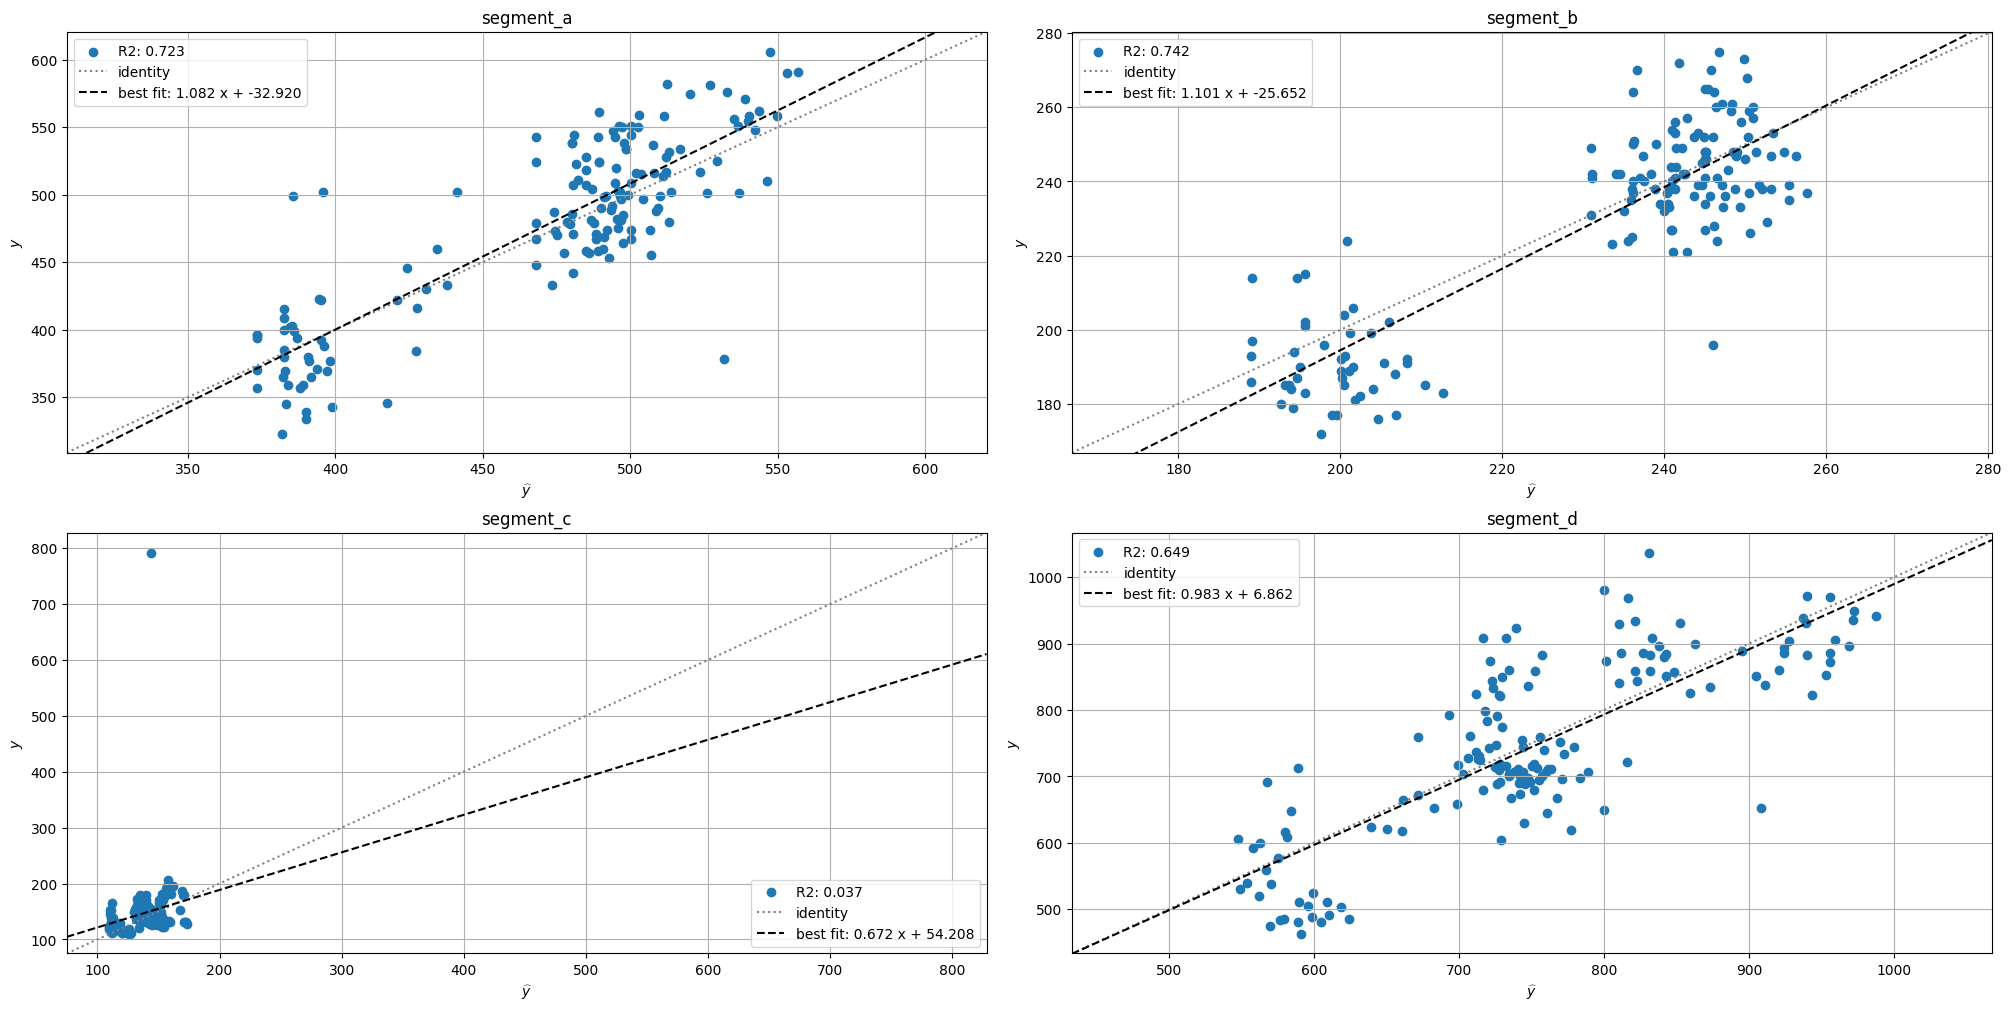

In [40]:
prediction_actual_scatter_plot(forecast_ts_list=forecast_ts_list, ts=ts_all)

That's all for this notebook. More features you can find in our documentation!